In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from ipywidgets import IntProgress
from IPython.display import display, HTML

In [2]:
contests = pd.read_csv('data/WorkedData.csv').drop(columns=['FillGapDollar'], axis=2).set_index('ContestId').dropna();

In [61]:
contests.columns

Index(['Success', 'SportName_NFL', 'SportName_PGA', 'SportName_SOCC',
       'SportName_MLB', 'SportName_NAS', 'SportName_CFB', 'SportName_MMA',
       'SportName_LOL', 'SportName_NHL', 'SportName_NBA', 'SportName_SOC',
       'SportName_CBB', 'SportName_GOLF', 'SportName_CFL', 'SportName_EL',
       'SportName_TEN', 'VariantName_Classic', 'VariantName_Weekend',
       'VariantName_Arcade', 'VariantName_WNBA', 'VariantName_Tiers',
       'VariantName_Playoff Arcade', 'VariantName_Late Swap',
       'VariantName_Final Series', 'VariantName_Tiers Late Swap',
       'VariantName_Showdown', 'VariantName_Match Play',
       'VariantName_Showdown Captain Mode', 'VariantName_Lowball',
       'VariantName_Single Match', 'Contest_Group_Headliner',
       'Contest_Group_Booster', 'Contest_Group_SingleEntry',
       'Contest_Group_FeaturedDoubleUp', 'Contest_Group_MultiPlayer',
       'Contest_Group_DoubleUp', 'Contest_Group_Satellite',
       'Contest_Group_Qualifier', 'Contest_Group_50/50', 'Co

## Helper functions

In [4]:
#Returns DF with ~50/50 split on specified binary column
def balanceDF(df, colName, numberOfEach = 0):
    successDF, failDF = df.loc[df[colName] == 1], df.loc[df[colName] == 0]
    if(numberOfEach == 0):
        maxContestsForBalance = min(len(successDF), len(failDF))
        numberOfEach = int(maxContestsForBalance*.1)
    combinedDF = pd.concat([cutDF(successDF, numberOfEach), cutDF(failDF, numberOfEach)])
    return combinedDF.sample(frac=1)
#Samples DF for an approximate numnber of rows
def cutDF(df, intendedNumber):
    df = df.sample(frac=intendedNumber/len(df), replace=True)
    return df

In [5]:
def spitTrainingTesting(df, percentTrain):
    df['is_train'] = np.random.uniform(0, 1, len(df)) <= percentTrain
    trainDF, testDF = df[df['is_train']==True], df[df['is_train']==False]
    df = df.drop(['is_train'], axis=1)
    trainDF = trainDF.drop(['is_train'], axis=1)
    testDF = testDF.drop(['is_train'], axis=1)
    return trainDF, testDF

In [6]:
classifiers = [RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier]
def getRandomClassifier(): 
    return classifiers[random.randint(0, len(classifiers)-1)]

In [7]:
def makeAndTrainClassifier(trainDF, classifierType): 
    clfFeatures = trainDF.columns.drop('Success')
    trainActual = trainDF['Success']
    clf = classifierType()
    clf.fit(trainDF[clfFeatures], trainActual)
    return clf

In [8]:
def classifierWrapper(trainDF, classifierType, balanced, numColumns = 0):
    #if numColumns is 0 or >#ofColumns, clf will train on all columns
    if(numColumns == 0  or numColumns > len(trainDF.columns)-1):
        numColumns = len(trainDF)
    columnDF = trainDF[trainDF.columns.drop('Success')].sample(numColumns, axis=1)
    columns  = pd.merge(trainDF[['Success']], columnDF, on='ContestId', how='left').columns
    if(balanced):
        trainDF = balanceDF(contests, 'Success')
    clf = makeAndTrainClassifier(trainDF[columns], classifierType)
    return clf, columns

In [9]:
def trainEnsemble(trainDF, numClassifiers = 100, classifierType = RandomForestClassifier, balanced = True):
    if classifierType == 'random':
        classifierType = getRandomClassifier()
    trainBar = IntProgress(min=0, max=numClassifiers, description='Training:')
    display(trainBar)
    clfs = []
    for c in range(0, numClassifiers):
        tDF = trainDF.copy()
        clf, cols = classifierWrapper(tDF, classifierType, balanced, numColumns=10)
        clfs.append({'clf': clf, 'cols':cols})
        trainBar.value += 1
    return clfs

def testEnsemble(testDF, ensemble):
    testBar = IntProgress(min=0, max=len(ensemble), description='Testing:')
    display(testBar)
    
    testActual = testDF['Success']
    clfFeatures = testDF[testDF.columns.drop('Success')]
    preds = []
    for clf in ensemble:
        preds.append(clf['clf'].predict(testDF[clf['cols'].drop('Success')]))
        testBar.value += 1
    return preds

In [10]:
accuracies = []
def makeEnsembleWithMinAcc(testDF, testActual, numClassifiers, minAcc, minLogThreshold = 1.0):
    goodCLFs = []
    genBar = IntProgress(min=0, max=numClassifiers, description='Collecting Accurate CLFs:')
    display(genBar)
    for i in range(0, numClassifiers):
        acc = 0
        clf, cols = 'err', 'err'
        while acc < minAcc:
            clf, cols = classifierWrapper(trainDF, RandomForestClassifier, True, numColumns = random.randint(10, 40))
#             clf, cols = classifierWrapper(trainDF, getRandomClassifier(), True, numColumns = random.randint(6, 20))
            pred = clf.predict(testDF[cols.drop('Success')])
            acc = accuracy_score(testActual, pred)
        if(acc > minLogThreshold):
            print("#"+str(len(goodCLFs)-1)+":", acc)
        accuracies.append(acc)
        goodCLFs.append({'clf': clf, 'cols':cols})
        genBar.value += 1
    return goodCLFs

In [11]:
def makeDiscrete(array, threshold, isArray=False):
    dArr = []
    for v in array:
        value = v
        if(isArray):
            value = sum(v)/float(len(v))
        if(value < threshold):
            dArr.append(0.)
        else:
            dArr.append(1.)
    return dArr

In [12]:
def combineCLFsPredictions(preds):
    numContests = len(preds)
    newPreds = []
    for c in range(0, len(preds[0])):
        predSum = 0
        for CLF in range(0, len(preds)):
            singlePred = preds[CLF][c]
            predSum += singlePred
        newPreds.append(predSum/(float(numContests)))
    return newPreds

## Make and Train Ensemble

In [13]:
df = contests.copy(deep=True)
trainDF, testDF = spitTrainingTesting(df, .75)
testActual = testDF.reset_index()['Success']

In [14]:
CLFs = makeEnsembleWithMinAcc(testDF, testActual, 100, .62, minLogThreshold=.75)

IntProgress(value=0, description='Collecting Accurate CLFs:')

## Saving CLF

In [17]:
from sklearn.externals import joblib
def saveCLF(clf, name):
    print(clf['cols'])
    joblib.dump(clf['clf'], name)
# saveCLF(CLFs[92], 'Classifier84Percent.joblib')

## Including FillGapDollars

In [15]:
fillgapDF = pd.read_csv('data/SuccessAndFillGapDollars.csv').set_index('ContestId')[['FillGapDollar']]

In [16]:
def getGap(df):
    combinedDF = pd.merge(df, fillgapDF, on='ContestId', how='left')
    combinedDF.head()
    return combinedDF['FillGapDollar'].sum()
def getTotalGap(df):
    return round(getGap(df),2)
def getAveGap(df):
    return round(getGap(df)/len(df),2)
def prettyDollars(newInt):
    return "$"+"{:,}".format(newInt)

## Generating False/True Positive/Negative columns

In [18]:
def getF2Split(df, PredVal= 0, TrueVal=0):
    splitDF = df.loc[df["Prediction"] == PredVal]
    splitDF = splitDF.loc[splitDF["Success"] == TrueVal]
    return splitDF
def getTruePositives(df):
    val = getF2Split(df, PredVal=1, TrueVal=1)
#     print("getTruePositives", len(val))
    return val
def getFalsePositives(df):
    val = getF2Split(df, PredVal=1, TrueVal=0)
#     print("getFalsePositives", len(val))
    return val
def getTrueNegatives(df):
    val = getF2Split(df, PredVal=0, TrueVal=0)
#     print("getTrueNegatives", len(val))
    return val
def getFalseNegatives(df):
    val = getF2Split(df, PredVal=0, TrueVal=1)
#     print("getFalseNegatives", len(val))
    return val

In [19]:
def f2Table(title, TN, FN, FP, TP):
    newStr = "<table>"
    newStr += "<tr><th colspan=\'2\'>"+title+"</th></tr>"
    newStr += "<tr><td>TN: "+str(TN)+"</td><td>FN: "+str(FN)+"</td></tr>"
    newStr += "<tr><td>FP: "+str(FP)+"</td><td>TP: "+str(TP)+"</td></tr>"
    newStr += "</table>"
    return display(HTML(newStr))
def f2TableFromMatrix(title, acc):
    return f2Table(title, acc[0][0], acc[0][1], acc[1][0], acc[1][1])

In [31]:
def getEnsembleResults(df, CLFs, threshold):
    localDF = df.copy(deep=True)
    preds = testEnsemble(localDF, CLFs)
    combinedPreds = combineCLFsPredictions(preds)
    return  localDF.assign(Prediction = makeDiscrete(combinedPreds, .5))[['Success', 'Prediction']]


In [32]:
def analyzeCLFs(df, CLFs):
    resultsDF = getEnsembleResults(df, CLFs, .5)
    FP = getFalsePositives(resultsDF)
    TP = getTruePositives(resultsDF)
    FN = getFalseNegatives(resultsDF)
    TN = getTrueNegatives(resultsDF)
    print("Accuracy:", accuracy_score(resultsDF['Prediction'], resultsDF['Success']))
    f2TableFromMatrix("F2 Counts", confusion_matrix(resultsDF['Prediction'], resultsDF['Success']))
    f2Table("Average FillGapDollars", prettyDollars(getAveGap(TN)), prettyDollars(getAveGap(FN)), prettyDollars(getAveGap(FP)), prettyDollars(getAveGap(TP)))
    f2Table("Total FillGapDollars", prettyDollars(getTotalGap(TN)), prettyDollars(getTotalGap(FN)), prettyDollars(getTotalGap(FP)), prettyDollars(getTotalGap(TP)))

    #     return resultsDF

## Testing

#### Normal

In [33]:
analyzeCLFs(testDF, CLFs)

IntProgress(value=0, description='Testing:')

Accuracy: 0.707174059319228


#### >= 100k

In [34]:
bigDF = pd.read_csv('data/BigContests.csv')[['ContestId']].set_index('ContestId')
bigTestDF = pd.merge(bigDF, testDF, on='ContestId', how='inner')
print(len(bigDF), "filtered to ", len(bigTestDF))
analyzeCLFs(bigTestDF, CLFs)

5401 filtered to  1358


IntProgress(value=0, description='Testing:')

Accuracy: 0.26435935198821797


#### < 100k

In [35]:
smallDF = pd.read_csv('data/SmallContests.csv')[['ContestId']].set_index('ContestId')
smallTestDF = pd.merge(smallDF, testDF, on='ContestId', how='inner')
analyzeCLFs(smallTestDF, CLFs)

IntProgress(value=0, description='Testing:')

Accuracy: 0.7137705876620213


## Threshold Test Functions

In [44]:
def getPredCost(rDF):
    fn = len(getFalseNegatives(rDF))
    fp = len(getFalsePositives(rDF))
#     print("fn:", fn, "   fp:", fp)
    return fp*10+fn

In [27]:
def getFNCost(rDF):
    fnGap = getAveGap(getFalseNegatives(rDF))
    return abs(fnGap)
def getFPCost(rDF):
    fpGap = getAveGap(getFalsePositives(rDF))
    return abs(fpGap)

## Determine Best Threshold

In [37]:
def meanPreds(preds):
    numCLF = len(preds)
    avgPreds = []
    for y in range(0, len(preds[0])):
        predSum = 0
        for x in range(0, len(preds)):
            predSum += preds[x][y]
        avgPreds.append(predSum/numCLF)
    return avgPreds

In [38]:
def testThresholds(avgPreds, func):
    trainBar = IntProgress(min=0, max=99, description='Testing Thresholds:')
    display(trainBar)
    
    localDF = testDF.copy(deep = True)
    thresholds, values = [], []
    for i in np.arange(0.01, 1, .01):
        thresholds.append(i)
        rDF = localDF.assign(Prediction = makeDiscrete(avgPreds, i))[['Success', 'Prediction']]
        values.append(func(rDF))
        trainBar.value+=1
    return thresholds, values

In [45]:
avgPreds = meanPreds(testEnsemble(testDF, CLFs))
thresholds, values = testThresholds(avgPreds, getPredCost)

IntProgress(value=0, description='Testing:')

IntProgress(value=0, description='Testing Thresholds:', max=99)

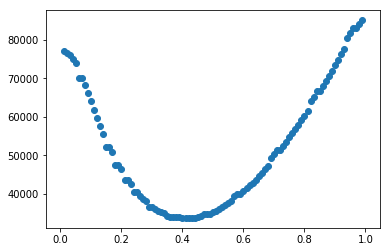

In [53]:
plt.scatter(thresholds, values)

In [60]:
t = thresholds[values.index(min(values))]
preds = makeDiscrete(avgPreds, t)
print(t)
print(accuracy_score(testActual, preds))
print(confusion_matrix(testActual, preds))

0.42000000000000004
0.7694197310662295
[[ 6360  1353]
 [20236 65680]]


## Frequent Columns

In [54]:
# Avg num columns
colCounts = {}
for c in CLFs:
    cols = c['cols'].drop('Success')
    for col in cols:
        if not(col in colCounts):
            colCounts[col] = 1
        else:
            colCounts[col] += 1

In [59]:
for col in colCounts:
    if colCounts[col] > 40:
        print(col, colCounts[col])

PaidUsersInDraftGroup_Scaled 74
SportName_PGA 41
TopPrize_Scaled 59
Contest_Group_Satellite 44
Contest_Group_Booster 44
MaxEntriesPerUser_Scaled 52
VariantName_Classic 41


### Required Accuracy:

In [33]:
numFail = len(contests.loc[contests['Success']==0])
print('Percent of contests that breakeven:', 1-numFail/len(contests))

Percent of contests that breakeven: 0.9557476004094012


In [46]:
bigDF = pd.read_csv('data/BigContests.csv')[['ContestId']].set_index('ContestId')
bigMergedDF = pd.merge(bigDF, contests, on='ContestId', how='inner')
numFail = len(bigMergedDF.loc[bigMergedDF['Success']==0])
print('Percent of contests that breakeven:', 1-numFail/len(bigMergedDF))

Percent of contests that breakeven: 0.9664814814814815


Bin contests to determine avg model

Kalman texbook from brandon